# Cross-Canada Survey of Radon Concentrations in Homes

In [8]:
import numpy as np
import requests
import pandas as pd
import plotly.express as px

print('Libraries imported')


Libraries imported


We downloaded the data online, however we had to download it as a csv file. In the file, there were additional columns that needed to be removed as the were empty. For the analysis we wish to coverm we are only interested in the Province/Territory variable.

In [25]:
url = "https://health.canada.ca/apps/open-data/radon-concentrations/radon-concentration.csv"

dfs = pd.read_csv(url)

dfs = dfs.drop(['ResultNumber','HealthRegionCode2007','ForwardSortationAreaCodes','Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12'],axis = 1)

dfs.head()

,ProvinceTerritory,Health Region2007,TestDurationInDays,AverageRadonConcentrationInBqPerM3
0,NL,Eastern Regional Integrated Health Authority,127.0,20
1,NL,Eastern Regional Integrated Health Authority,108.0,36
2,NL,Eastern Regional Integrated Health Authority,91.0,<15
3,NL,Eastern Regional Integrated Health Authority,91.0,31
4,NL,Eastern Regional Integrated Health Authority,98.0,26


To do the statistical tests on the dataset, we needed the Average Radon Concentration to be integer values. To achieve this we had to remove the values that were "<15", now this will cause some issues with the analysis but without speaking to the owner of the dataset, there is nothing we can do about this.

In [26]:
for badLabel in ['<15']:
    dfs = dfs[dfs["AverageRadonConcentrationInBqPerM3"] != badLabel]

dfs = dfs[dfs["AverageRadonConcentrationInBqPerM3"].notnull()]
dfs["AverageRadonConcentrationInBqPerM3"].unique()

dfs['AverageRadonConcentrationInBqPerM3'] = dfs['AverageRadonConcentrationInBqPerM3'].astype(int)

dfs.describe()

,TestDurationInDays,AverageRadonConcentrationInBqPerM3
count,11229.000000,11229.000000
mean,96.509128,116.907828
std,14.099348,183.050599
min,30.000000,15.000000
25%,91.000000,30.000000
50%,92.000000,72.000000
75%,97.000000,133.000000
max,386.000000,5657.000000


We wanted to see if there were any significant differences between the provinces. The first step would be to group by the province/territory and find some summary statistics.

In [15]:
dfsbyPT = dfs.groupby('ProvinceTerritory')
dfsbyPT.describe()

TestDurationInDays                                          \
                               count       mean        std   min   25%   50%   
ProvinceTerritory                                                              
AB                            1077.0  96.747447  13.298870  45.0  91.0  92.0   
BC                            1162.0  95.119621  12.749031  58.0  91.0  92.0   
MB                            1102.0  95.242287  11.656463  57.0  91.0  92.0   
NB                             728.0  96.888736  16.535651  48.0  91.0  92.0   
NL                             479.0  97.348643  12.766717  61.0  91.0  92.0   
NS                             428.0  97.623832  19.327235  53.0  91.0  92.0   
NT                             146.0  94.972603   9.637531  57.0  91.0  93.0   
NU                              11.0  94.545455   6.137811  91.0  92.0  92.0   
ON                            3292.0  97.154921  15.818507  30.0  91.0  92.0   
PE                              71.0  98.225352  12.474199  86.0  91.0  92.0   
QC                            1348.0  97.441395  13.654512  51.0  91.0  92.0   
SK                            1169.0  95.378956  10.226256  35.0  91.0  92.0   
YT                             216.0  94.939815  12.850883  32.0  91.0  92.0   

                                 AverageRadonConcentrationInBqPerM3  \
                      75%    max                              count   
ProvinceTerritory                                                     
AB                  98.00  226.0                             1077.0   
BC                  95.00  369.0                             1162.0   
MB                  96.00  217.0                             1102.0   
NB                  98.00  386.0                              728.0   
NL                 100.00  189.0                              479.0   
NS                  99.00  302.0                              428.0   
NT                  96.00  139.0                              146.0   
NU                  94.00  112.0                               11.0   
ON                  98.00  381.0                             3292.0   
PE                 101.00  154.0                               71.0   
QC                  98.00  210.0                             1348.0   
SK                  96.00  191.0                             1169.0   
YT                  94.25  215.0                              216.0   

                                                                               
                         mean         std   min    25%    50%     75%     max  
ProvinceTerritory                                                              
AB                  96.046425   95.152537  15.0  37.00   75.0  121.00  1391.0  
BC                 102.542169  167.349146  15.0  25.00   55.0  110.00  2941.0  
MB                 160.348457  177.987718  15.0  55.00  110.5  203.00  1903.0  
NB                 203.230769  336.061973  15.0  37.00  104.0  227.00  5590.0  
NL                  86.991649  142.047475  15.0  22.00   35.0   97.00  1548.0  
NS                 125.728972  265.850976  15.0  25.00   42.5  114.25  2692.0  
NT                  85.910959  101.656346  15.0  29.00   58.0  109.75   924.0  
NU                  24.545455    7.802098  15.0  20.00   23.0   26.00    41.0  
ON                  97.383961  160.787093  15.0  28.00   63.0  114.00  5657.0  
PE                  68.070423   76.382183  15.0  22.50   31.0   87.00   415.0  
QC                 104.034866  161.933688  15.0  26.00   55.0  121.00  2923.0  
SK                 130.225834  137.278958  15.0  60.00  100.0  159.00  2165.0  
YT                 182.027778  313.686081  15.0  43.75   92.5  165.75  2357.0

The next step will be to graph the values and see if they follow a normal distribution. Using a histogram, we can see that any assumption of normality is broken.

Text(0.5, 0.09, 'Concentration (Bq/m^3)')

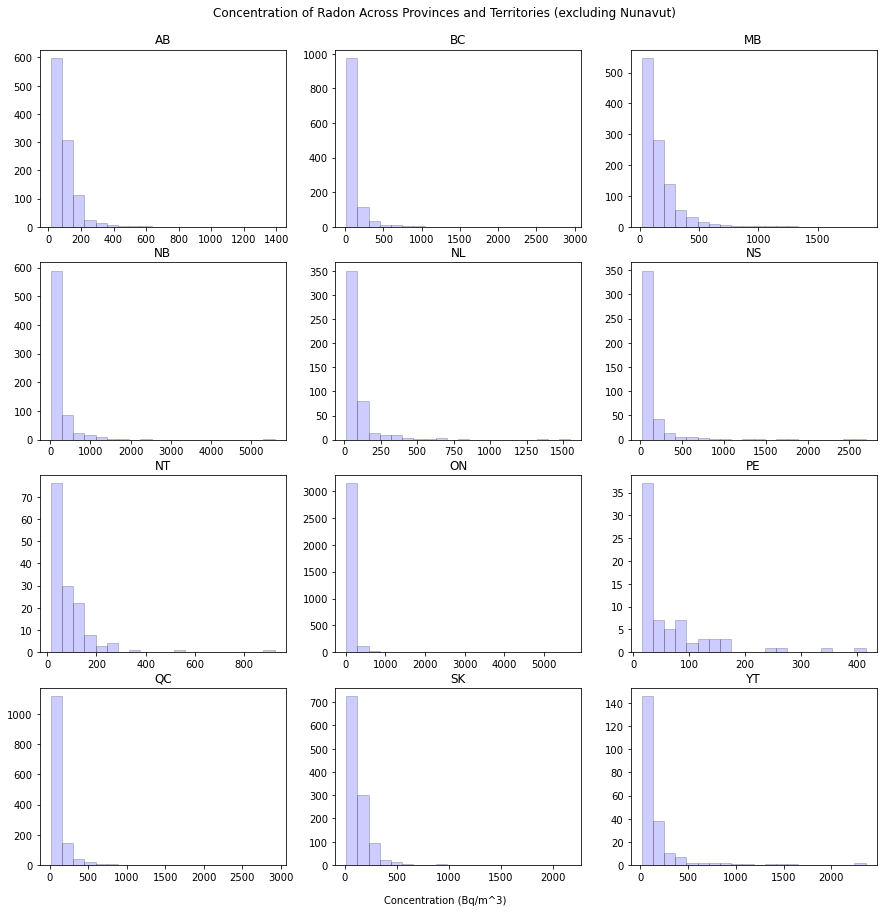

In [30]:
dfs_noNU = dfs[dfs["ProvinceTerritory"] != 'NU']
dfsbyPT_noNU = dfs_noNU.groupby("ProvinceTerritory")
fig, axs = plt.subplots(4,3)
fig.set_size_inches(15,15)
a = 0
for P in list(dfsbyPT_noNU.groups.keys()):
#    print(a%2)
    axs[int((a-a%3)/3),a%3].hist(dfsbyPT_noNU.get_group(P)['AverageRadonConcentrationInBqPerM3'],20,density=False,
    alpha=0.2,
    color='blue',
    edgecolor='k')
    axs[int((a-a%3)/3),a%3].set_title(P)
    a = a+1
fig.suptitle('Concentration of Radon Across Provinces and Territories (excluding Nunavut)',x=0.5,y=0.92)
fig.text(0.5, 0.09, 'Concentration (Bq/m^3)', ha='center')

We can log transform the data but since there is a lower limit to the data, there is not much we can do about the normality of the data. We also see that when we consider the territory Nunavet, there are only 11 observations which will drastically change our analysis, so we will drop them from the dataset.

[Text(0, 0, 'AB'),
 Text(0, 0, 'BC'),
 Text(0, 0, 'MB'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'NL'),
 Text(0, 0, 'NS'),
 Text(0, 0, 'NT'),
 Text(0, 0, 'NU'),
 Text(0, 0, 'ON'),
 Text(0, 0, 'PE'),
 Text(0, 0, 'QC'),
 Text(0, 0, 'SK'),
 Text(0, 0, 'YT')]

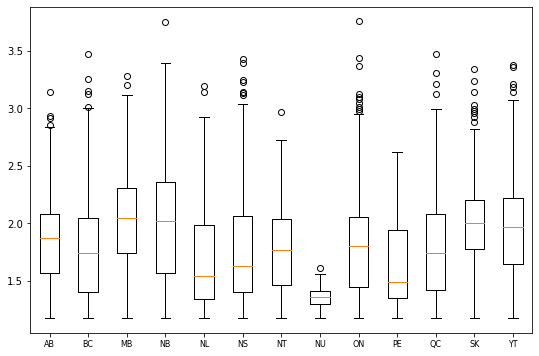

In [20]:
data_to_plot = []

for P in dfsbyPT.groups.keys():
    temp = np.log10(dfsbyPT.get_group(P)['AverageRadonConcentrationInBqPerM3'])
    data_to_plot.append(temp)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels( dfsbyPT.groups.keys(), fontsize = 8)
#plt.xticks(np.arange(1,14), dfsbyPT.groups.keys())

Since we can not assume normality, we have to use a non-parametric anova test. To do so we will use the Kruskal Wallis test.

In [21]:
from scipy import stats

AB = data_to_plot[0]
BC = data_to_plot[1]
MB = data_to_plot[2]
NB = data_to_plot[3]
NL = data_to_plot[4]
NS = data_to_plot[5]
NT = data_to_plot[6]
ON = data_to_plot[8]
PE = data_to_plot[9]
QC = data_to_plot[10]
SK = data_to_plot[11]
YT = data_to_plot[12]

stats.kruskal(AB,BC,MB,NB,NL,NS,NT,ON,PE,QC,SK,YT)

KruskalResult(statistic=713.8841997074114, pvalue=5.693026989867524e-146)

Since there is a significant difference between the provinces, we can use a post hoc test to find the pairwise comparisons. To correct for FWER we will use a sidak correction.

In [29]:
import scikit_posthocs as sp

data = [AB,BC,MB,NB,NL,NS,NT,ON,PE,QC,SK,YT]
sp.posthoc_dunn(data, p_adjust = 'sidak')

,1,2,3,4,5,6,7,8,9,10,11,12
1,1.000000e+00,3.722462e-08,0.000000e+00,9.303912e-08,3.663736e-14,1.138069e-04,5.956655e-01,5.283673e-06,1.388570e-03,1.458035e-05,1.230283e-11,6.420348e-02
2,3.722462e-08,1.000000e+00,0.000000e+00,0.000000e+00,4.981123e-02,1.000000e+00,1.000000e+00,8.700289e-01,8.993220e-01,9.999998e-01,0.000000e+00,4.915268e-10
3,0.000000e+00,0.000000e+00,1.000000e+00,9.998059e-01,0.000000e+00,0.000000e+00,2.562996e-09,0.000000e+00,3.118572e-11,0.000000e+00,9.999996e-01,9.995101e-01
4,9.303912e-08,0.000000e+00,9.998059e-01,1.000000e+00,0.000000e+00,0.000000e+00,1.392546e-06,0.000000e+00,4.394014e-09,0.000000e+00,1.000000e+00,1.000000e+00
5,3.663736e-14,4.981123e-02,0.000000e+00,0.000000e+00,1.000000e+00,4.825388e-01,6.604065e-01,1.042252e-05,1.000000e+00,7.778942e-04,0.000000e+00,0.000000e+00
6,1.138069e-04,1.000000e+00,0.000000e+00,0.000000e+00,4.825388e-01,1.000000e+00,1.000000e+00,9.989275e-01,9.727061e-01,1.000000e+00,0.000000e+00,3.437078e-08
7,5.956655e-01,1.000000e+00,2.562996e-09,1.392546e-06,6.604065e-01,1.000000e+00,1.000000e+00,1.000000e+00,9.103169e-01,1.000000e+00,1.156161e-07,1.031956e-03
8,5.283673e-06,8.700289e-01,0.000000e+00,0.000000e+00,1.042252e-05,9.989275e-01,1.000000e+00,1.000000e+00,3.067263e-01,1.000000e+00,0.000000e+00,4.407541e-08
9,1.388570e-03,8.993220e-01,3.118572e-11,4.394014e-09,1.000000e+00,9.727061e-01,9.103169e-01,3.067263e-01,1.000000e+00,5.196503e-01,6.601613e-10,1.397013e-06
10,1.458035e-05,9.999998e-01,0.000000e+00,0.000000e+00,7.778942e-04,1.000000e+00,1.000000e+00,1.000000e+00,5.196503e-01,1.000000e+00,0.000000e+00,2.984396e-08
